# Демодуляция. 
# Часть 2. Double Sideband Transmitted Carrier 
# (AM-DSB-TC)

## 1. Когерентная демодуляция с помощью PLL

Для качественного приема АМ-сигналов когерентным способом необходимо точное совпадение частоты и фазы несущей и генератора в приемнике. Чтобы этого добиться, нужно использовать систему фазовой автоподстройки частоты (phase-locked loop - PLL). В этом случае схема приемного устройства будет иметь вид:

<img src="../../images/DSB_TC_Receiver_2_1.png" width=500/>

Классическая PLL состоит из трех основных блоков: фазового детектора (phase detector - PD), петлевого фильтра (loop filter - LF) и генератора, управляемого напряжением (numericaly controled oscillator - NCO). Фазовый детектор вычисляет разность фаз между несущей и NCO. Схема PLL представлена ниже:

<img src="../../images/DSB_TC_Receiver_2_2.png" width=500/>

Фазовый детектор можно реализовать с помощью обычного умножителя. Будем считать, что несущую можно представить в виде:

$$u_c =A\cdot \sin \left(\omega_с t+\phi_0 \right)=A\cdot \sin \left(\Phi_с \left(t\right)\right).$$

Также пусть мгновенная фаза несущей в момент времени $t_0$ равна $\Phi_с \left(t_0 \right)$ рад., а фаза NCO - $\Phi_{\textrm{NCO}} \left(t_0 \right)=\Phi_с \left(t_0 \right)-\Delta$рад. Тогда получаем:

 $$A\cdot \sin \left(\Phi_с \left(t_0 \right)\right)\cdot \cos \left(\Phi_{\textrm{NCO}} \left(t_0 \right)\right)=A\cdot \sin \left(\Phi_с \left(t_0 \right)\right)\cdot \cos \left(\Phi_с \left(t_0 \right)-\Delta \right)=A\cdot 0\ldotp 5\cdot \sin \left(\Delta \right)+A\cdot 0\ldotp 5\cdot \sin \left(2\Phi_c \left(t_0 \right)-\Delta \right).$$
 
Слагаемое с удвоенной частотой можно убрать с помощью низкочастотного фильтра. Если этого не сделать, то оно в любом случае в дальнейшем будет удалено с помощью петлевого фильтра. Поэтому данным слагаемым можно пренебречь. То есть, отклик фазового детектора можно считать равным $A\cdot 0\ldotp 5\cdot \sin \left(\Delta \right)$. В случае, когда PLL находится в режиме синхронизации, расстройка по фазе будет близка к нулю, а значит $\sin \left(\Delta \right)\simeq \Delta \ldotp$ Таким образом, сигнал на выходе детектора будет приближенно равен $A\cdot 0\ldotp 5\cdot \Delta$. Величину $k_d =A\cdot 0\ldotp 5$ называют коэффициентом усиления детектора. Обратите внимание, что она зависит от амплитуды несущей.

Сигнал с выхода фазового детектора передается на вход петлевого фильтра, который удаляет шумы, присутствующий в сигнале, а также задает динамические характеристики PLL. Обычно фильтр реализуется в виде пропорциональной и интегрирующей ветвей, коэффициенты усиления которых равны $k_p$ и $k_i$ соответственно. Схема фильтра представлена ниже:

<img src="../../images/DSB_TC_Receiver_2_3.png" width=500/>

Эти коэффициенты рассчитываются на основе других характеристик PLL, а именно коэффициента демпфирования и шумовой полосы. Коэффициент демпфирования определяет степень осциляций при вхождении PLL в режим синхронизации. Шумовая полоса характеризует, как сильно будет ослаблятся шум на выходе PLL. Чем меньше полоса - тем меньше шума. Однако, уменьшение шумовой полосы приводит к существенному увеличению времени вхождения в режим синхронизации и уменьшает полосу захвата PLL. Формулы для расчета коэффициентов фильтра представлены ниже:

$$k_p =\frac{4\cdot \zeta \cdot B_n }{k_d \cdot \left(\zeta +\frac{1}{4\cdot \zeta }\right)},$$    
$$k_i =\frac{4\cdot {B_n }^2 }{k_d \cdot {\left(\zeta +\frac{1}{4\cdot \zeta }\right)}^2 },$$

где $\zeta$ - коэффициент демпфирования, $B_n$ = $B\cdot f_s$ - нормированная шумовая полоса, $B$- шумовая полоса в герцах, $f_s$ - частота дискретизации в герцах.

Сигнал с выхода петлевого фильтра изменяется частоту управляемого генератор и тем самым подстраивает его фазу для уменьшения ошибки $\Delta$. Значание фазы NCO в аналитическом виде можно записать так:

$$\Phi_{\textrm{NCO}} \left(t\right)=\int_{-\infty }^t \left(\omega_0 +u_f \left(\tau \right)\right)d\tau ,$$

где $\omega_0$ - частота NCO при отсутствии входнго воздействия, $u_f \left(t\right)$ - сигнал на выходе петлевого фильтра. Таким образом, управляемый генератор по сути представляет из себя интегратор.

Так как в случаем DSB-TC модуляции несущая в сигнале присутствует в явном виде, для ее восстановления можно принятый сигнал непосредственно подавать на вход PLL. 

Для реализации всех рассмотренных выше преобразований был создан класс Am_signal_pll, описывающий работу PLL. Обработка одной пачки отсчетов сигнала запускается с помощью метода step, который возвращает значения частотной расстройки и отсчеты восстановленной несущей.

In [1]:
%matplotlib notebook
%reset -f

import numpy as np

class Am_signal_pll:
    
    def __init__(self, 
                 sample_frequency,   # sample frequency in herz
                 noise_bandwidth,    # noise bandwidth in herz
                 damping_factor,     # damping factor
                 central_frequency,  # central NCO frequency in herz
                 signal_amp):        # signal amplitude
        
        self.central_frequency = central_frequency
        self.sample_frequency = sample_frequency
        
        self.ts = 1/self.sample_frequency  # sample time
        BL_n = noise_bandwidth * self.ts   # normalized noise bandwidth
        
        ksi = damping_factor
        kd = 0.5 * signal_amp  # phase detector gain   

        self.kp = 4*ksi*BL_n / (ksi + 0.25/ksi) / kd
        self.ki = 4*BL_n**2 / (ksi + 0.25/ksi)**2 / kd

        # PLL internal variables
        self.NCO_phase = 0
        self.loop_filter_acc = 0

        
    def step(self, input_frame):
        frame_size = input_frame.size
            
        output_frame = np.zeros(frame_size)
        frequency_error = np.zeros(frame_size)
            
        for n in range(frame_size):
            # умножение сигнала на сигнал от NCO
            phase_error = input_frame[n] * np.cos(self.NCO_phase)

            # петлевой фильтр
            kp_out = self.kp * phase_error
            ki_out = self.ki * phase_error + self.loop_filter_acc
            loop_filter_out = kp_out + ki_out

            # обновление состояния накопителя в петлевом фильтре
            self.loop_filter_acc = ki_out;

            # обновление фазы NCO
            self.NCO_phase = self.NCO_phase + loop_filter_out + 2*np.pi*self.central_frequency*self.ts

            # формирование выходных значений
            frequency_error[n] = loop_filter_out / (2*np.pi) * self.sample_frequency 
            output_frame[n] = np.cos(self.NCO_phase)
            
        return frequency_error, output_frame 

Ниже представлен скрипт, выполняющий когерентный прием сигнала с амплитудной модуляцией. С помощью переменной freq_offset можно изменять расстройку между частотой несущей и начальной частотой управляемого генератора.

<IPython.core.display.Javascript object>


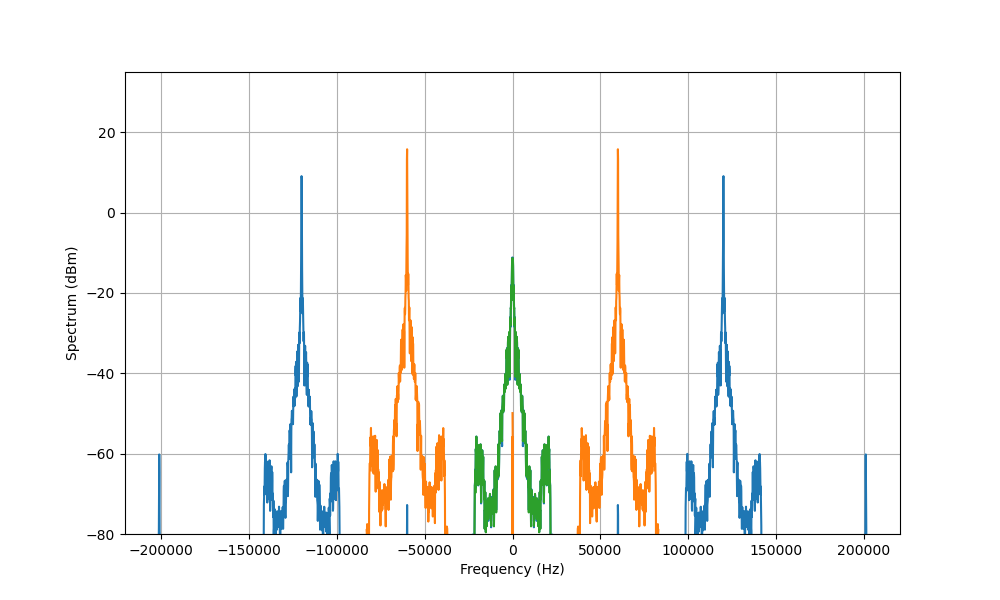

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей
freq_offset = 1000         # расстройка по частоте (Hz)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_TC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# создаем объект PLL
am_pll = Am_signal_pll(
    sample_frequency = signal_fs,
    noise_bandwidth = 100,
    damping_factor = 0.7,
    central_frequency = Fc + freq_offset,
    signal_amp = 0.27
    )

# получение коэффициентов ФНЧ
H = firls(175, (0, 20e3, 30e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-80, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []
FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                          # выделяем один канал и нормируем отсчеты к единице
    
    # формируем несущую c помощью PLL
    _, carrier = am_pll.step(am_signal)
    
    # смешивание АМ-сигнала и несущей
    mixed_signal = am_signal * carrier;
    
    # фильтрация сигнала
    baseband_signal, FIR_tap_values = lfilter(H, 1.0, np.real(mixed_signal), zi=FIR_tap_values)
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = mixed_signal, am_signal, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)



Выше представлены преобразования в частотной области. Оранжевым обозначен спектр принимаемого АМ-сигнала. Синим - спектр на выходе смесителя. Можно увидеть, что он состоит из информационного сообщения и сигнала на удвоенной частоте несущей. После фильтрации остается только информационное сообщение (зеленый).

На слух можно оценить, что при расстройке в 100 Гц демодулированный сигнал не содержит искажений. При расстройке в 1000 Гц сначала слышен сильный свист, а потом качество сигнала исправляется. Этот временный свист соответствует периоду вхождения PLL в режим синхронизации. Из-за большей расстройки по частоте длительность этого процесса увеличивается. При расстройке в 5000 Гц, слышны сильные искажения. Это происходит из-за того, что расстройка по частоте превышает полосу захвата PLL, поэтому PLL не может войти в режим синхронизации.

## 2. Когерентная демодуляция при квадратурном приеме

Рассмотрим как изменится структура когерентного демодулятора в случае квадратурного приема. Сигнал теперь комплексный с односторонним спектром. Для восстановления несущей также необходимо использовать PLL. Отличае от случая действительнго сигнала заключается в устройстве фазового детектора. При квадратурном приеме несущую можно представить в виде комплексной экспоненты ${A\cdot e}^{j\cdot \Phi_с \left(t\right)}$. Выходной сигнал NCO также будет комплексным - $e^{-j\cdot \Phi_{\textrm{NCO}} \left(t\right)}$. Как и ранее через $\Phi_с \left(t\right)$ и $\Phi_{\textrm{NCO}} \left(t\right)=\Phi_с \left(t\right)-\Delta$ обозначены мгновенные фазы несущей и NCO. Фазовый детектор представляет из себя умножитель, после которого располается блок вычисления аргумента комплексного числа. Это можно записать в аналитическом виде:

$${s_{\textrm{mix}} =A\cdot e}^{j\cdot \Phi_с \left(t\right)} \cdot e^{-j\cdot \Phi_{\textrm{NCO}} \left(t\right)} ={A\cdot e}^{j\cdot \left\lbrack \Phi_с \left(t\right)-\Phi_с \left(t\right)+\Delta \right\rbrack } ={A\cdot e}^{j\cdot \Delta } ,$$

$$s_d =\arg \left\lbrace s_{\textrm{mix}} \right\rbrace =\arg \left\lbrace {A\cdot e}^{j\cdot \Delta } \right\rbrace =\Delta ,$$

где $s_{\textrm{mix}}$ - сигнал на выходе умножителя, а $s_d$- сигнал на выход фазового детектора.

Можно увидеть, что в случае квадратурного приема сигнал на выходе фазового детектора не зависит от амплитуды несущей, а коэффициент усиления детектора $k_d$ равен единице. Остальная часть PLL полностью совпадает с реализацией для действительного принимаемого сигнала.

Для реализации всех рассмотренных выше преобразований был создан класс Am_complex_pll, описывающий работу PLL. Обработка одной пачки отсчетов сигнала запускается с помощью метода step, который возвращает значения частотной расстройки и отсчеты восстановленной несущей.



In [1]:
%matplotlib notebook
%reset -f

import numpy as np

class Am_complex_pll:
    
    def __init__(self, 
                 sample_frequency,   # sample frequency in herz
                 noise_bandwidth,    # noise bandwidth in herz
                 damping_factor,     # damping factor
                 central_frequency): # central NCO frequency in herz        
        
        self.central_frequency = central_frequency
        self.sample_frequency = sample_frequency
        
        self.ts = 1/self.sample_frequency  # sample time
        BL_n = noise_bandwidth * self.ts   # normalized noise bandwidth
        
        ksi = damping_factor
        
        self.kp = 4*ksi*BL_n / (ksi + 0.25/ksi) 
        self.ki = 4*BL_n**2 / (ksi + 0.25/ksi)**2

        # PLL internal variables
        self.NCO_phase = 0
        self.loop_filter_acc = 0

        
    def step(self, input_frame):
        frame_size = input_frame.size
            
        output_frame = np.zeros(frame_size, dtype=complex)
        frequency_error = np.zeros(frame_size)
            
        for n in range(frame_size):
            # умножение сигнала на сигнал от NCO
            phase_error = np.angle( input_frame[n] * np.exp(-1j * self.NCO_phase) )
            
            # петлевой фильтр
            kp_out = self.kp * phase_error
            ki_out = self.ki * phase_error + self.loop_filter_acc
            loop_filter_out = kp_out + ki_out

            # обновление состояния накопителя в петлевом фильтре
            self.loop_filter_acc = ki_out;

            # обновление фазы NCO
            self.NCO_phase = self.NCO_phase + loop_filter_out + 2*np.pi*self.central_frequency*self.ts

            # формирование выходных значений
            frequency_error[n] = loop_filter_out / (2*np.pi) * self.sample_frequency 
            output_frame[n] = np.exp(1j * self.NCO_phase)
            
        return frequency_error, output_frame 

Ниже представлен скрипт, выполняющий когерентный прием сигнала с амплитудной модуляцией. С помощью переменной freq_offset можно изменять расстройку между частотой несущей и начальной частотой управляемого генератора.

<IPython.core.display.Javascript object>


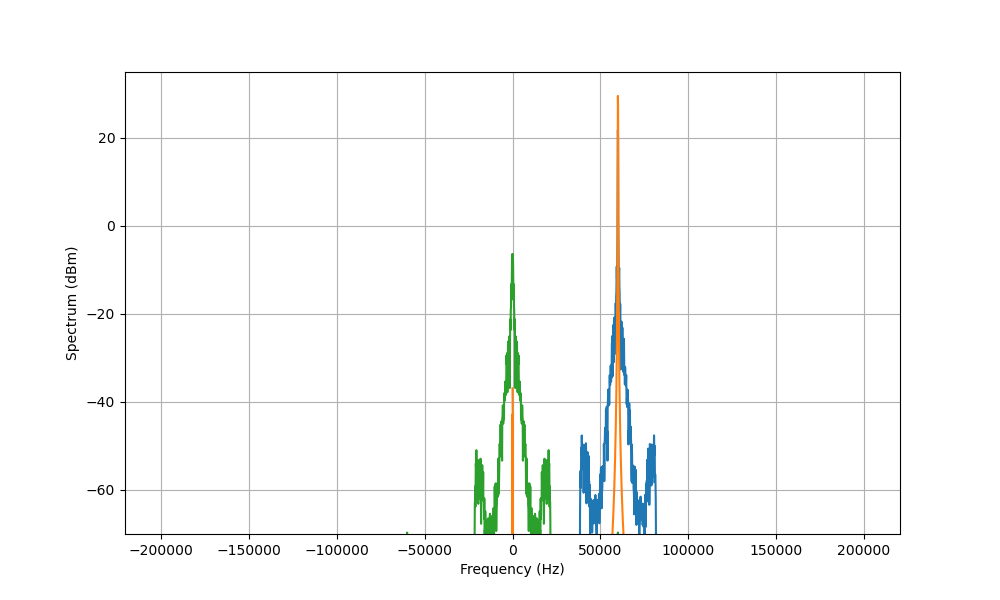

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей

freq_offset = 1000               # расстройка по частоте (Hz)
phase_offset = 0 * np.pi/180  # расстройка по фазе (градусы)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_TC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# создаем объект PLL
am_pll = Am_complex_pll(
    sample_frequency = signal_fs,
    noise_bandwidth = 100,
    damping_factor = 0.7,
    central_frequency = Fc + freq_offset
    )

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-70, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = (am_signal[:,0] + 1j*am_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
    # формируем несущую c помощью PLL
    _, carrier = am_pll.step(am_signal)
    
    # смешивание АМ-сигнала и несущей и выделение действительной части
    baseband_signal = np.real(am_signal * np.conj(carrier))
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = am_signal, carrier, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены преобразования в частотной области. Синим обозначен спектр принимаемого АМ-сигнала. Так как прием квадратурный, спектр сигнала комплексный и расположен только в положительной области частот. Оранжевым цветом представлен сигнал на выходе NCO PLL, а зеленым - сигнал на выходе смесителя. 

При прослушавании принятого сигнала при разных значениях расстройки по частоте получаем те же самые искажения, что и для действительного случая. При расстройке по частоте в 5000 Гц сигнал на выходе NCO содержит множество гармоник и не является комплексной экспонентой. Это означает, что PLL не находится в режиме синхронизации.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR
- F. Gardner Phaselock Techniques
- M. Rice Digital Communications. A Discrete Time Approach